# Named Entity Recognition
In Natural Language Processing (NLP) an Entity Recognition is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. 
Information about lables: 
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

        1. Total Words Count = 1354149 
        2. Target Data Column: Tag

#### Importing Libraries

In [2]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

In [12]:
#Reading the csv file
df = pd.read_csv('ner_dataset.csv', encoding = "ISO-8859-1")

In [24]:
#Display first 10 rows
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [5]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 36965,the,NN,O
freq,1,52573,145807,887908


#### Observations : 
* There are total 47959 sentences in the dataset.
* Number unique words in the dataset are 35178.
* Total 17 lables (Tags).

In [6]:
#Displaying the unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [7]:
#Checking null values, if any.
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

There are lots of missing values in 'Sentence #' attribute. So we will use pandas fillna technique and use 'ffill' method which propagates last valid observation forward to next.

In [13]:
df = df.fillna(method = 'ffill')

In [14]:
# This is a class te get sentence. The each sentence will be list of tuples with its tag and pos.
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [15]:
#Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [16]:
#sentence with its pos and tag.
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


Getting all the sentences in the dataset.

In [17]:
sentences = getter.sentences

#### Defining the parameters for LSTM network

In [18]:
# Number of data points passed in each iteration
batch_size = 64 
# Passes through entire dataset
epochs = 8
# Maximum length of review
max_len = 75 
# Dimension of embedding vector
embedding = 40 

#### Preprocessing Data
We will process our text data before feeding to the network.
* Here word_to_index dictionary used to convert word into index value and tag_to_index is for the labels. So overall we represent each word as integer.

In [26]:
#Getting unique words and labels from data
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [17]:
print("The word India is identified by the index: {}".format(word_to_index["India"]))
print("The label B-org for the organization is identified by the index: {}".format(tag_to_index["B-org"]))

The word India is identified by the index: 2570
The label B-org for the organization is identified by the index: 6


In [31]:
# Converting each sentence into list of index from list of tokens
X = [[word_to_index[w[0]] for w in s] for s in sentences]

# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

In [32]:
# Convert label to index
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [33]:
num_tag = df['Tag'].nunique()
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [22]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (40765, 75)
Size of training output data :  (40765, 75, 18)
Size of testing input data :  (7194, 75)
Size of testing output data :  (7194, 75, 18)


In [23]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [24]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[2] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


#### Bidirectional LSTM-CRF Network

In [96]:
num_tags = df['Tag'].nunique()
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 75, 40)            1407200   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_8 (CRF)                  (None, 75, 18)            1278      
Total params: 1,449,928
Trainable params: 1,449,928
Non-trainable params: 0
_________________________________________________________________


Making Checkpoint each epoch to check and save the best model performance till last and also avoiding further validation loss drop due to overfitting.

In [25]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [119]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])

Train on 36688 samples, validate on 4077 samples
Epoch 1/8
36688/36688 [==============================] - 251s 7ms/step - loss: 8.8293 - crf_viterbi_accuracy: 0.9762 - val_loss: 8.7456 - val_crf_viterbi_accuracy: 0.9693
Epoch 2/8
36688/36688 [==============================] - 249s 7ms/step - loss: 8.8255 - crf_viterbi_accuracy: 0.9776 - val_loss: 8.7474 - val_crf_viterbi_accuracy: 0.9692
Epoch 3/8
36688/36688 [==============================] - 250s 7ms/step - loss: 8.8225 - crf_viterbi_accuracy: 0.9787 - val_loss: 8.7480 - val_crf_viterbi_accuracy: 0.9669
Epoch 4/8
36688/36688 [==============================] - 250s 7ms/step - loss: 8.8199 - crf_viterbi_accuracy: 0.9796 - val_loss: 8.7469 - val_crf_viterbi_accuracy: 0.9695
Epoch 5/8
36688/36688 [==============================] - 250s 7ms/step - loss: 8.8174 - crf_viterbi_accuracy: 0.9810 - val_loss: 8.7537 - val_crf_viterbi_accuracy: 0.9668
Epoch 6/8
36688/36688 [==============================] - 251s 7ms/step - loss: 8.8150 - crf_vite

In [99]:
history.history.keys()

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

Visualizing the performance of model.

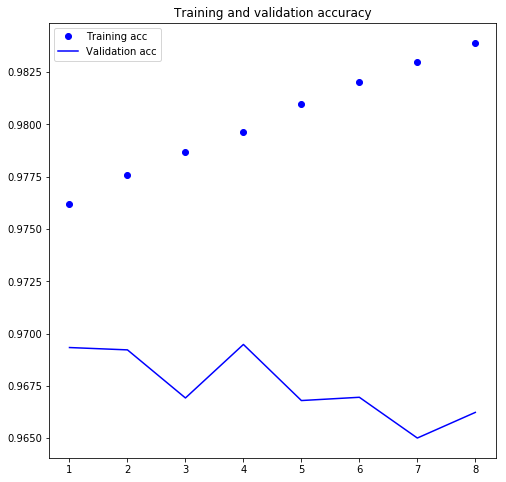

In [120]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

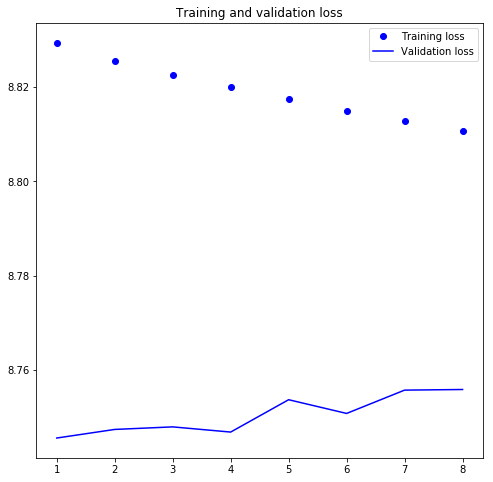

In [121]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Evaluating the model on test set

In [59]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [60]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [61]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 90.4%


In [62]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00        47
      B-eve       0.56      0.19      0.29        47
      B-geo       0.86      0.93      0.89      5632
      B-gpe       0.97      0.94      0.96      2418
      B-nat       0.00      0.00      0.00        30
      B-org       0.84      0.75      0.79      3001
      B-per       0.90      0.85      0.87      2562
      B-tim       0.93      0.90      0.91      3031
      I-art       0.00      0.00      0.00        27
      I-eve       0.00      0.00      0.00        40
      I-geo       0.80      0.86      0.83      1086
      I-gpe       1.00      0.52      0.68        25
      I-nat       0.00      0.00      0.00         6
      I-org       0.80      0.85      0.82      2436
      I-per       0.90      0.90      0.90      2626
      I-tim       0.86      0.74      0.80       941
          O       0.99      0.99      0.99    132279
        PAD       1.00      1.00      1.00   

In [147]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 3435 of 7194 (Test Set)
Word           ||True ||Pred
It             : O     O
is             : O     O
the            : O     O
second         : O     O
major          : O     O
quarterly      : O     O
loss           : O     O
for            : O     O
Citigroup      : B-org B-org
,              : O     O
and            : O     O
it             : O     O
is             : O     O
the            : O     O
latest         : O     O
in             : O     O
a              : O     O
wave           : O     O
of             : O     O
dismal         : O     O
bank           : O     O
earning        : O     O
reports        : O     O
over           : O     O
the            : O     O
past           : B-tim B-tim
week           : O     O
.              : O     O


The results looks quite interesting.

#### Save the result

In [119]:
with open('word_to_index.pickle', 'wb') as f:
    pickle.dump(word_to_index, f)

with open('tag_to_index.pickle', 'wb') as f:
    pickle.dump(tag_to_index, f)